<a href="https://colab.research.google.com/github/mehrotrasan16/CS581-CAN-DO-Project/blob/sanketm-lstm-experiments/code/LSTM_CAN_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [46]:
# from google.colab import drive
# drive.mount('/content/drive')

In [47]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import recall_score, f1_score

import numpy as np
import pandas as pd
from numpy import load
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


# Load Datasets

### Combining Attack-free + DoS datasets 
 Here we work with the Attack-Free and DoS Datasets to get one less biased and slightly better distributed dataset to train and test on.

In [48]:
dosdf = pd.read_csv('c:/Users/User/OneDrive - Ministere de l\'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/data/DoS_attack_dataset1.csv')
dosdf['label'] = np.where(dosdf['CAN ID'] == 0,1,0)
dosdf = dosdf.drop(labels=['Timestamp'],axis=1)
dosdf

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0,0,8,0,0,0,0,0,0,0,0,1
1,128,0,8,0,23,220,9,22,17,22,187,0
2,0,0,8,0,0,0,0,0,0,0,0,1
3,129,0,8,64,132,135,0,0,0,0,107,0
4,0,0,8,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
656574,0,0,8,0,0,0,0,0,0,0,0,1
656575,129,0,8,64,132,137,0,0,0,0,240,0
656576,0,0,8,0,0,0,0,0,0,0,0,1
656577,399,0,8,0,59,24,0,0,63,0,0,0


In [49]:
df = pd.read_csv('c:/Users/User/OneDrive - Ministere de l\'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/data/Attack_free_dataset1.csv')
df['label'] = 0
df = df.drop(columns=['Timestamp'])
df

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,790,0,8,5,32,234,10,32,26,0,127,0
1,809,0,8,215,167,127,140,17,47,0,16,0
2,128,0,8,0,23,234,10,32,26,32,67,0
3,129,0,8,127,132,96,0,0,0,0,83,0
4,288,0,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2369393,68,0,8,0,0,0,255,111,0,0,0,0
2369394,357,0,8,17,232,127,0,0,0,12,138,0
2369395,688,0,5,35,0,0,7,172,0,0,0,0
2369396,1200,0,8,0,0,0,0,0,0,0,0,0


* Here we toss out the timestamp column as in this approach it is not informative about the nature of the outlier.
* It also helps us balance out the problems encountered in the previous attack-free and Dos attack experiments.

* in the attack free dataset - all the packets were normal data and so had to be labelled with only one value, training a model on single class data does not means it learns anything.

* in the Dos Attack dataset, every second message is a dos attack message, leaving the dataset evenly split 50:50 on anomalies/normal network data, but there is not enough contiguous network data for it to learn normal state nor attack state, and as a result it's accuracy will average around 50%

In [50]:
#add the two dataframes
newdf = pd.concat([df,dosdf],axis=0)

In [51]:
# newdf = df.append(dosdf)
# # newdf

In [52]:
df.groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398


In [53]:
335624/2690353

0.1247509155861703

## Baseline LSTM

### Train-test-split



In [54]:
newdf=newdf.sample(frac=1,random_state=200) #random state is a seed value 200 

series = newdf.to_numpy()
series = series[ : , :, np.newaxis] 
print(series.shape)

n_features = series.shape[1]
train_split = int(series.shape[0]*0.7)
print(f'train split : {train_split}')

val_split = int(series.shape[0]*0.8)

X_train, y_train = series[:train_split, :n_features-1], series[:train_split, -1] # -1 references the last column
X_valid, y_valid = series[train_split:val_split, :n_features-1], series[train_split:val_split, -1]
X_test, y_test = series[val_split:, :n_features-1], series[val_split:, -1]


(3025977, 12, 1)
train split : 2118183


In [55]:
#X_train stats
newdf[:train_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,1883438,1883438,1883438,1883438,1883438,1883438,1883438,1883438,1883438,1883438,1883438
1,234745,234745,234745,234745,234745,234745,234745,234745,234745,234745,234745


In [56]:
1-(234533/1883650)

0.8754901388262151

In [57]:
#X_valid split
newdf[train_split:val_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,269110,269110,269110,269110,269110,269110,269110,269110,269110,269110,269110
1,33488,33488,33488,33488,33488,33488,33488,33488,33488,33488,33488


In [58]:
1-(33852/268746)

0.8740371949722042

In [59]:
#X_test
newdf[val_split:].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,537805,537805,537805,537805,537805,537805,537805,537805,537805,537805,537805
1,67391,67391,67391,67391,67391,67391,67391,67391,67391,67391,67391


In [95]:
newdf.head()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
1946611,809,0,8,133,180,127,140,17,44,0,16,0
586564,399,0,8,0,42,30,0,0,63,0,0,0
1280689,880,0,8,255,32,0,128,255,0,0,100,0
2267591,790,0,8,5,23,236,9,23,21,0,127,0
1834588,1415,0,8,0,0,0,0,0,0,0,1,0


In [105]:
test=newdf.iloc[0:2,:-1]
test
test.to_csv('test.csv',index=False)

In [97]:
#copy de 1 row newdf sans le label
test=newdf.iloc[0,:-1]
test
#save as csv
test.to_csv('test.csv',index=False)


In [60]:
1-(67239/537957)

0.8750104562260552

In [61]:
X_train.shape, y_train.shape,X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((2118183, 11, 1),
 (2118183, 1),
 (302598, 11, 1),
 (302598, 1),
 (605196, 11, 1),
 (605196, 1))

### Vanilla LSTM Model

In [62]:
tf.keras.backend.clear_session()

In [63]:
rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(10,input_shape=[X_train.shape[1],1]),
    # keras.layers.Flatten(),
    keras.layers.Dense(2, activation='sigmoid')
])
rnnmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print(rnnmodel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [64]:
rnnmodel.layers[0]

In [65]:
tf.keras.utils.plot_model(rnnmodel,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [66]:
early_stop=keras.callbacks.EarlyStopping(monitor='loss',patience=10)

rnnhistory = rnnmodel.fit(X_train,y_train,
                          epochs=1,
                          batch_size=256,
                          validation_data=(X_valid,y_valid),
                          callbacks=[early_stop])

8275/8275 [==============================] - 25s 3ms/step - loss: 0.0076 - accuracy: 0.9982 - val_loss: 8.2678e-06 - val_accuracy: 1.0000


### Evaluation and plotting


In [67]:
scores = rnnmodel.evaluate(X_test,y_test)
print(f"Loss, Accuracy: {scores}")

18913/18913 [==============================] - 29s 2ms/step - loss: 8.2802e-06 - accuracy: 1.0000
Loss, Accuracy: [8.280165275209583e-06, 1.0]


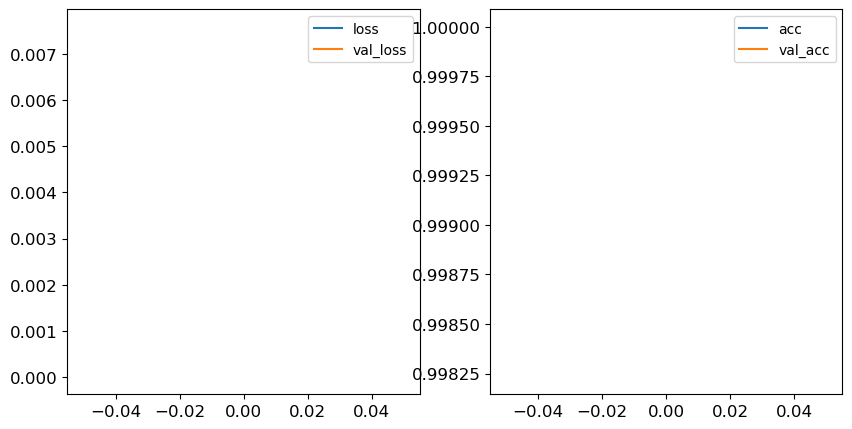

In [68]:
plt.subplot(1,2,1)
plt.plot(rnnhistory.history["loss"])
plt.plot(rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(rnnhistory.history["accuracy"])
plt.plot(rnnhistory.history["val_accuracy"])
plt.legend(('acc','val_acc'))

plt.gcf().set_size_inches((10,5))
plt.show()

In [69]:
y_pred = rnnmodel.predict(X_test)
y_pred

18913/18913 [==============================] - 31s 2ms/step


array([[0.9984285 , 0.00545989],
       [0.99858636, 0.00488075],
       [0.99843675, 0.00545531],
       ...,
       [0.9991116 , 0.00492564],
       [0.9990622 , 0.00462421],
       [0.9992978 , 0.00501994]], dtype=float32)

In [70]:
classes = np.array([np.argmax(i) for i in y_pred])
classes[:20]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

In [71]:
np.unique(classes)

array([0, 1], dtype=int64)

In [72]:
X_test[30],y_test[30], np.argmax(y_pred[30])

(array([[357],
        [  0],
        [  8],
        [  8],
        [  8],
        [128],
        [  0],
        [  0],
        [  0],
        [  7],
        [135]], dtype=int64),
 array([0], dtype=int64),
 0)

In [73]:
recall_score(y_test,classes)

1.0

In [74]:
predlist = classes.reshape((classes.shape[0],1))
y_test.shape, y_pred.shape, predlist.shape

((605196, 1), (605196, 2), (605196, 1))

In [75]:
compdf = pd.DataFrame(predlist)
compdf['real'] = y_test
compdf = compdf.rename(columns={0:'pred'})
compdf['T/F Prediction'] = np.where(compdf['pred'] == compdf['real'],True, False)
compdf

,pred,real,T/F Prediction
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,1,1,True
...,...,...,...
605191,0,0,True
605192,1,1,True
605193,0,0,True
605194,0,0,True


In [76]:
np.unique(compdf.loc[compdf.real == 1]['T/F Prediction'])

array([ True])

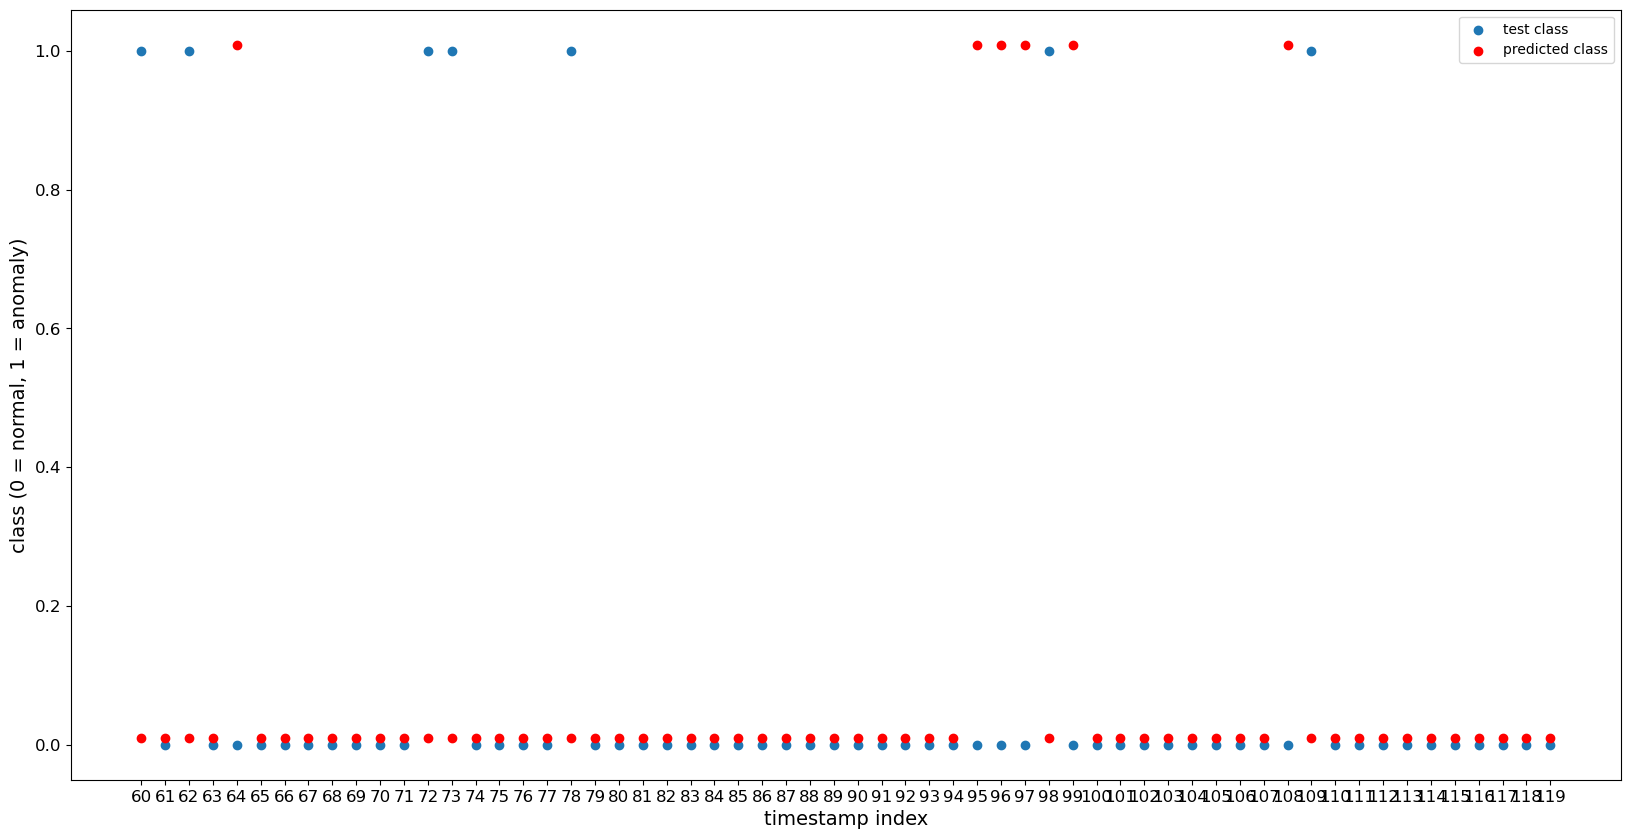

In [90]:
plot_min=60
plot_max =120
plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.009 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
plt.legend(('test class','predicted class'))
plt.xlabel('timestamp index')
plt.ylabel('class (0 = normal, 1 = anomaly)')
plt.xticks(ticks=range(plot_min, plot_max))
plt.gcf().set_size_inches((20,10))
# plt.gcf().autofmt_xdate()
plt.show()

### Saving and Checking the size of the Model

In [78]:
saved_model_dir = 'c:/Users/User/OneDrive - Ministere de l\'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/lsmt-models/'
rnnmodel.save(saved_model_dir + "lstm-combinedmodel.h5",include_optimizer=False)
print(f"Saving Model to: {saved_model_dir}lstm-combinedmodel.h5")

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/lsmt-models/lstm-combinedmodel.h5


c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [79]:
print(f'Size of the model without compression: {os.path.getsize(saved_model_dir + "lstm-combinedmodel.h5")/float(2**20)} Mb')

Size of the model without compression: 0.0157012939453125 Mb


# Ablation study

**Dataset chosen for these experiments:** Attack-free + Dos  dataset, wherever it is not explicitly mentioned otherwise.

# Effect of Model Size and Layers

### Train-test-split



In [80]:
newdf=newdf.sample(frac=1,random_state=200) #random state is a seed value 200 

series = newdf.to_numpy()
series = series[ : , :, np.newaxis] 
print(series.shape)

n_features = series.shape[1]
train_split = int(series.shape[0]*0.7)
print(f'train split : {train_split}')

val_split = int(series.shape[0]*0.8)

X_train, y_train = series[:train_split, :n_features-1], series[:train_split, -1] # -1 references the last column
X_valid, y_valid = series[train_split:val_split, :n_features-1], series[train_split:val_split, -1]
X_test, y_test = series[val_split:, :n_features-1], series[val_split:, -1]


(3025977, 12, 1)
train split : 2118183


In [81]:
#X_train stats
newdf[:train_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,1883650,1883650,1883650,1883650,1883650,1883650,1883650,1883650,1883650,1883650,1883650
1,234533,234533,234533,234533,234533,234533,234533,234533,234533,234533,234533


In [82]:
1-(234533/1883650)

0.8754901388262151

In [83]:
#X_valid split
newdf[train_split:val_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,268746,268746,268746,268746,268746,268746,268746,268746,268746,268746,268746
1,33852,33852,33852,33852,33852,33852,33852,33852,33852,33852,33852


In [84]:
1-(33852/268746)

0.8740371949722042

In [85]:
#X_test
newdf[val_split:].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,537957,537957,537957,537957,537957,537957,537957,537957,537957,537957,537957
1,67239,67239,67239,67239,67239,67239,67239,67239,67239,67239,67239


In [86]:
1-(67239/537957)

0.8750104562260552

In [87]:
X_train.shape, y_train.shape,X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((2118183, 11, 1),
 (2118183, 1),
 (302598, 11, 1),
 (302598, 1),
 (605196, 11, 1),
 (605196, 1))

In this section we experiment with ranges of 4 values of different hyper parameters to see their effect on accuracy on the Impersonation Attack Dataset.

## Number of cells


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 2)                 12        
                                                                 
Total params: 152 (608.00 Byte)
Trainable params: 152 (608.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
18913/18913 [==============================] - 21s 1ms/step - loss: 3.9318e-05 - accuracy: 1.0000
Loss, Accuracy: [3.93179398088

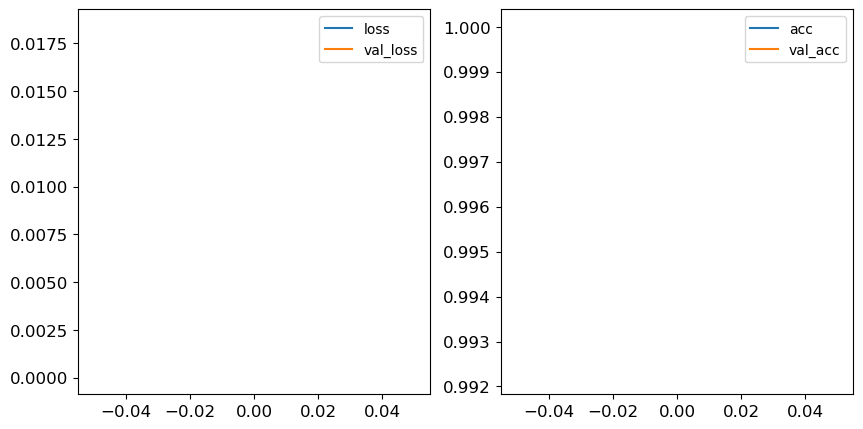

18913/18913 [==============================] - 18s 949us/step


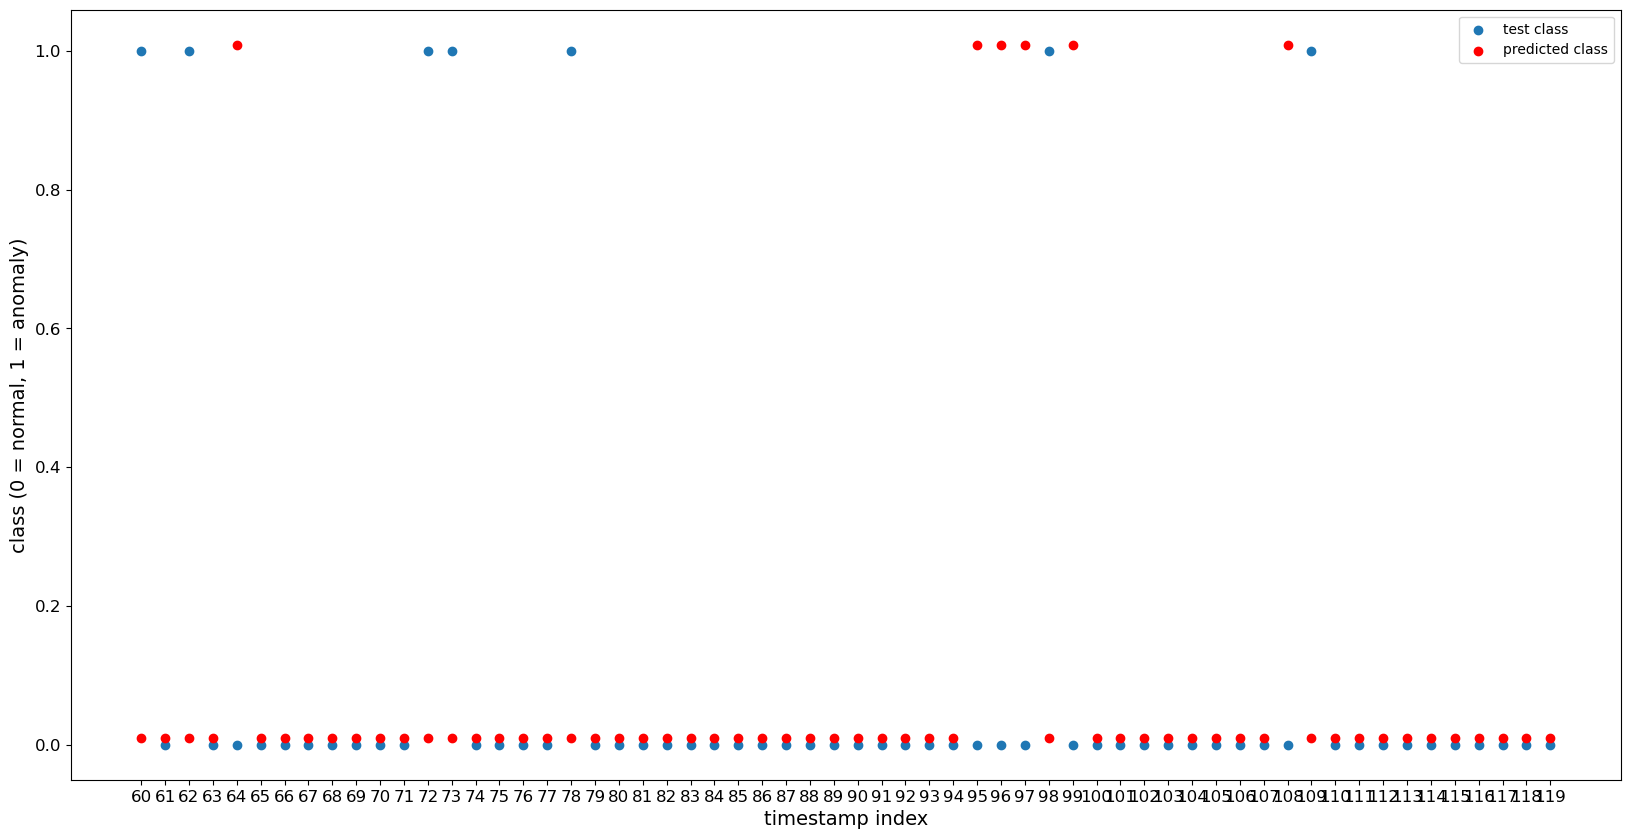

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-5cell.h5
Size of the 5 cell model : 0.01653289794921875 Mb
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 2)                 42        
                                                                 
Total params: 1802 (7.04 KB)
Trainable params: 1802 (7.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graph

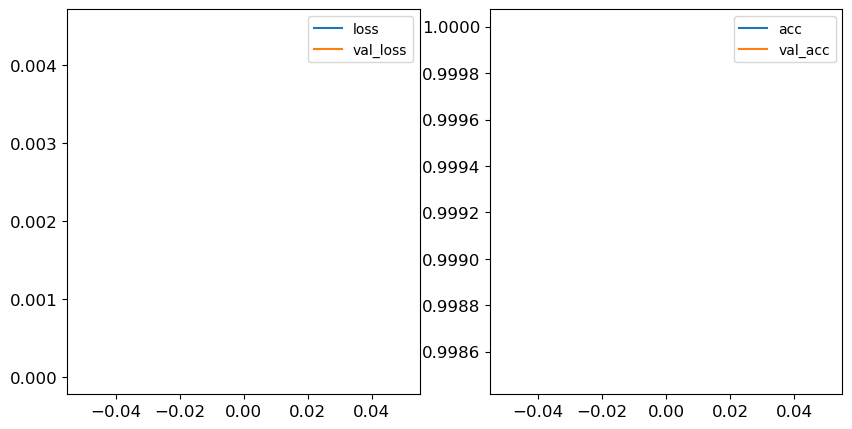

18913/18913 [==============================] - 31s 2ms/step


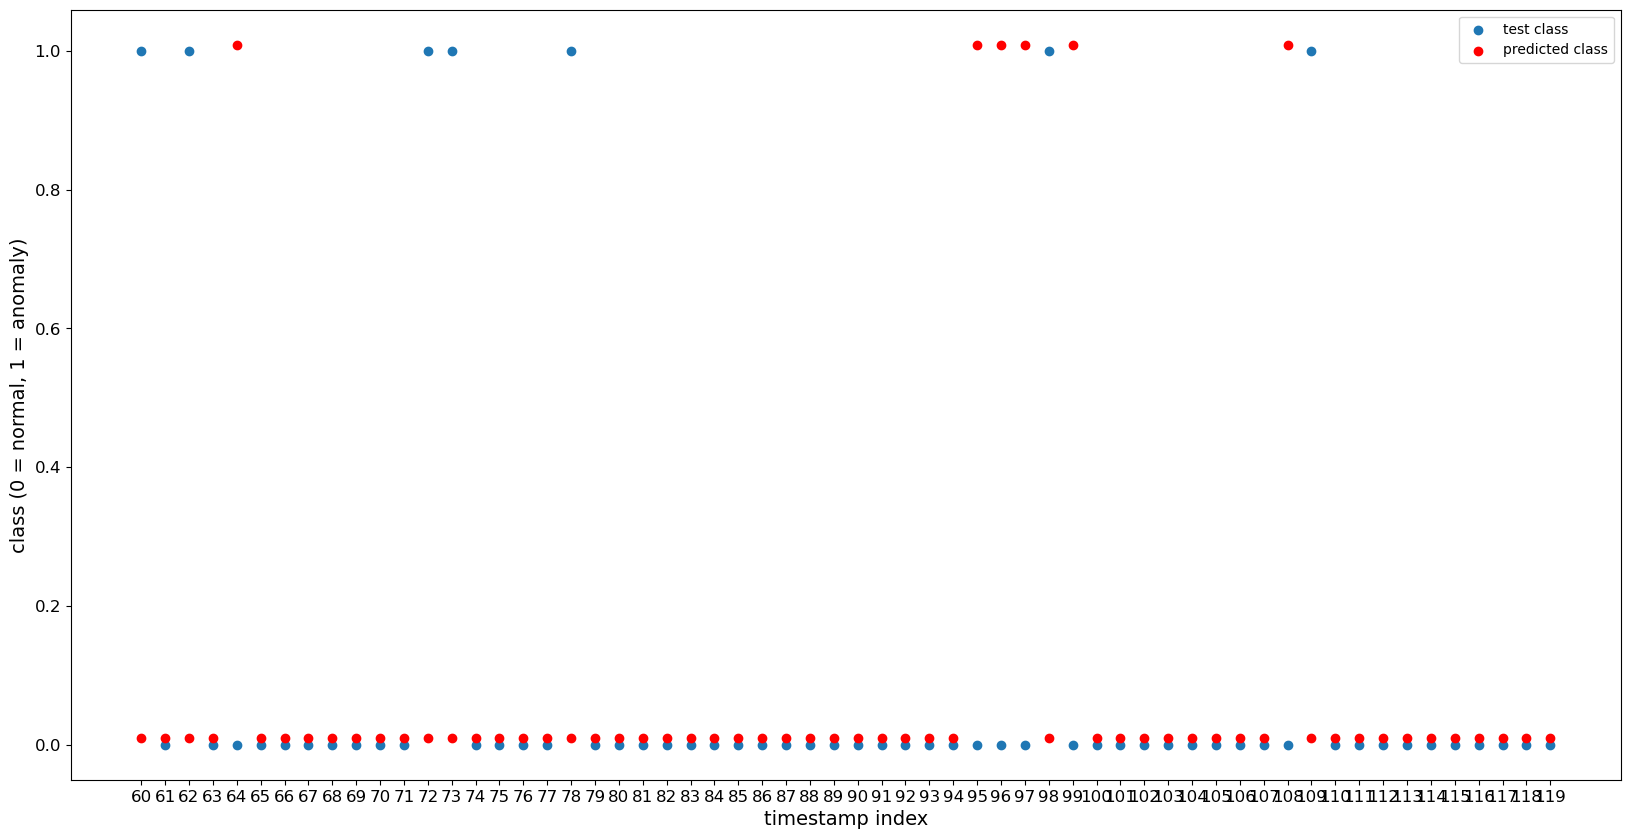

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-20cell.h5
Size of the 20 cell model : 0.02263641357421875 Mb
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 41002 (160.16 KB)
Trainable params: 41002 (160.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and insta

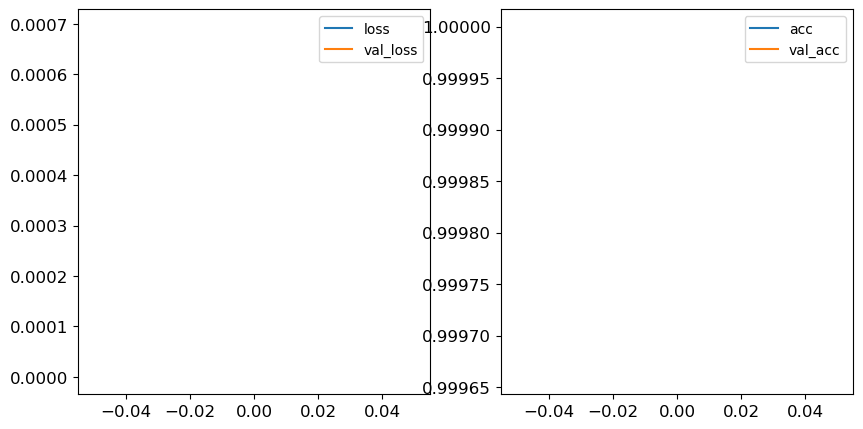

18913/18913 [==============================] - 50s 3ms/step


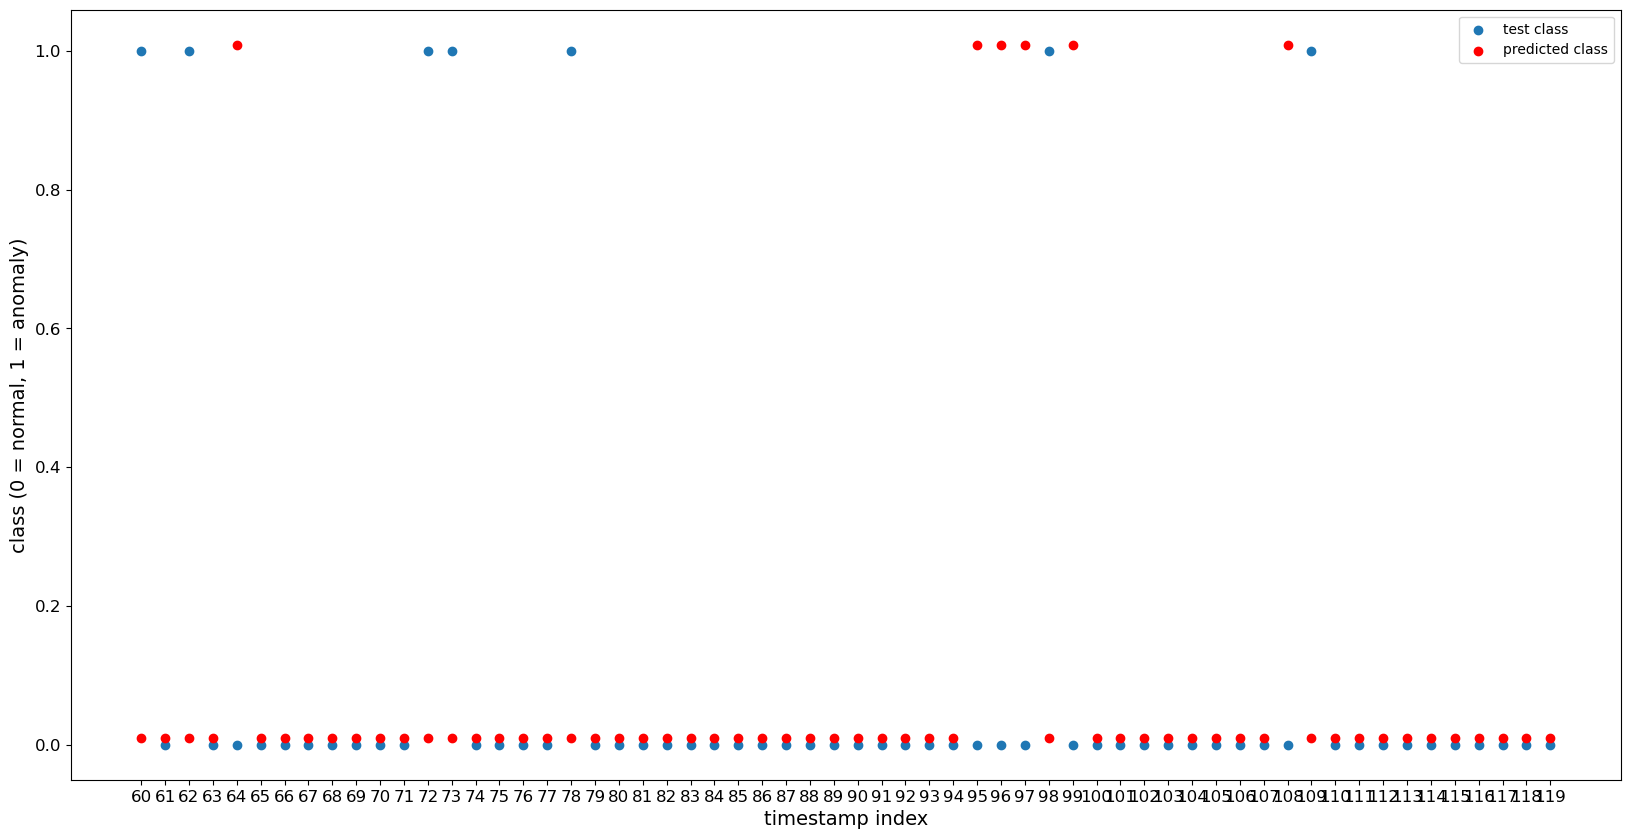

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-100cell.h5
Size of the 100 cell model : 0.1732635498046875 Mb


In [91]:
num_cells = [5,20,100]
for cells in num_cells:
    tf.keras.backend.clear_session()
    rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(cells,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='sigmoid')
    ])
    rnnmodel.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    print(rnnmodel.summary())
    tf.keras.utils.plot_model(rnnmodel,show_shapes=True)
    early_stop=keras.callbacks.EarlyStopping(monitor='loss',patience=10)

    rnnhistory = rnnmodel.fit(X_train,y_train,
                            epochs=1,
                            batch_size=256,
                            validation_data=(X_valid,y_valid),
                            callbacks=[early_stop])
    scores = rnnmodel.evaluate(X_test,y_test)
    print(f"Loss, Accuracy: {scores}")
    plt.subplot(1,2,1)
    plt.plot(rnnhistory.history["loss"])
    plt.plot(rnnhistory.history["val_loss"])
    plt.legend(('loss','val_loss'))
    plt.subplot(1,2,2)
    plt.plot(rnnhistory.history["accuracy"])
    plt.plot(rnnhistory.history["val_accuracy"])
    plt.legend(('acc','val_acc'))

    plt.gcf().set_size_inches((10,5))
    plt.show()

    y_pred = rnnmodel.predict(X_test)

    plot_min=60
    plot_max =120
    plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
    plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.009 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
    plt.legend(('test class','predicted class'))
    plt.xlabel('timestamp index')
    plt.ylabel('class (0 = normal, 1 = anomaly)')
    plt.xticks(ticks=range(plot_min, plot_max))
    plt.gcf().set_size_inches((20,10))
    # plt.gcf().autofmt_xdate()
    plt.show()

    saved_model_dir = 'c:/Users/User/OneDrive - Ministere de l\'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/'
    rnnmodel.save(saved_model_dir + f"lstm-{cells}cell.h5",include_optimizer=False)
    print(f"Saving Model to: {saved_model_dir}lstm-{cells}cell.h5")
    print(f'Size of the {cells} cell model : {os.path.getsize(saved_model_dir + f"lstm-{cells}cell.h5")/float(2**20)} Mb')

### Comparison Table

| Metric\cells | 5 | 10 | 20 |100|
|---|---|---|---|---|
|Accuracy(%)|0.9858|0.9918|0.9874|0.9982|
|Size(MB)|0.015|0.015|0.021|0.17|
|Total Parameters|152|502|1802|41002|
|Inference Time(sec)|22|66|25|48|

## Activation function

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
18913/18913 [==============================] - 29s 2ms/step - loss: 0.0770 - accuracy: 0.8889
Loss, Accuracy: [0.0770111009478569, 0.888

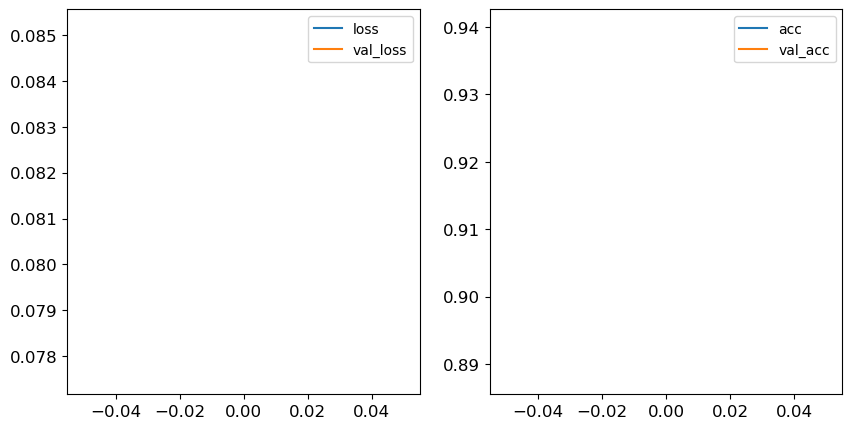

18913/18913 [==============================] - 28s 1ms/step


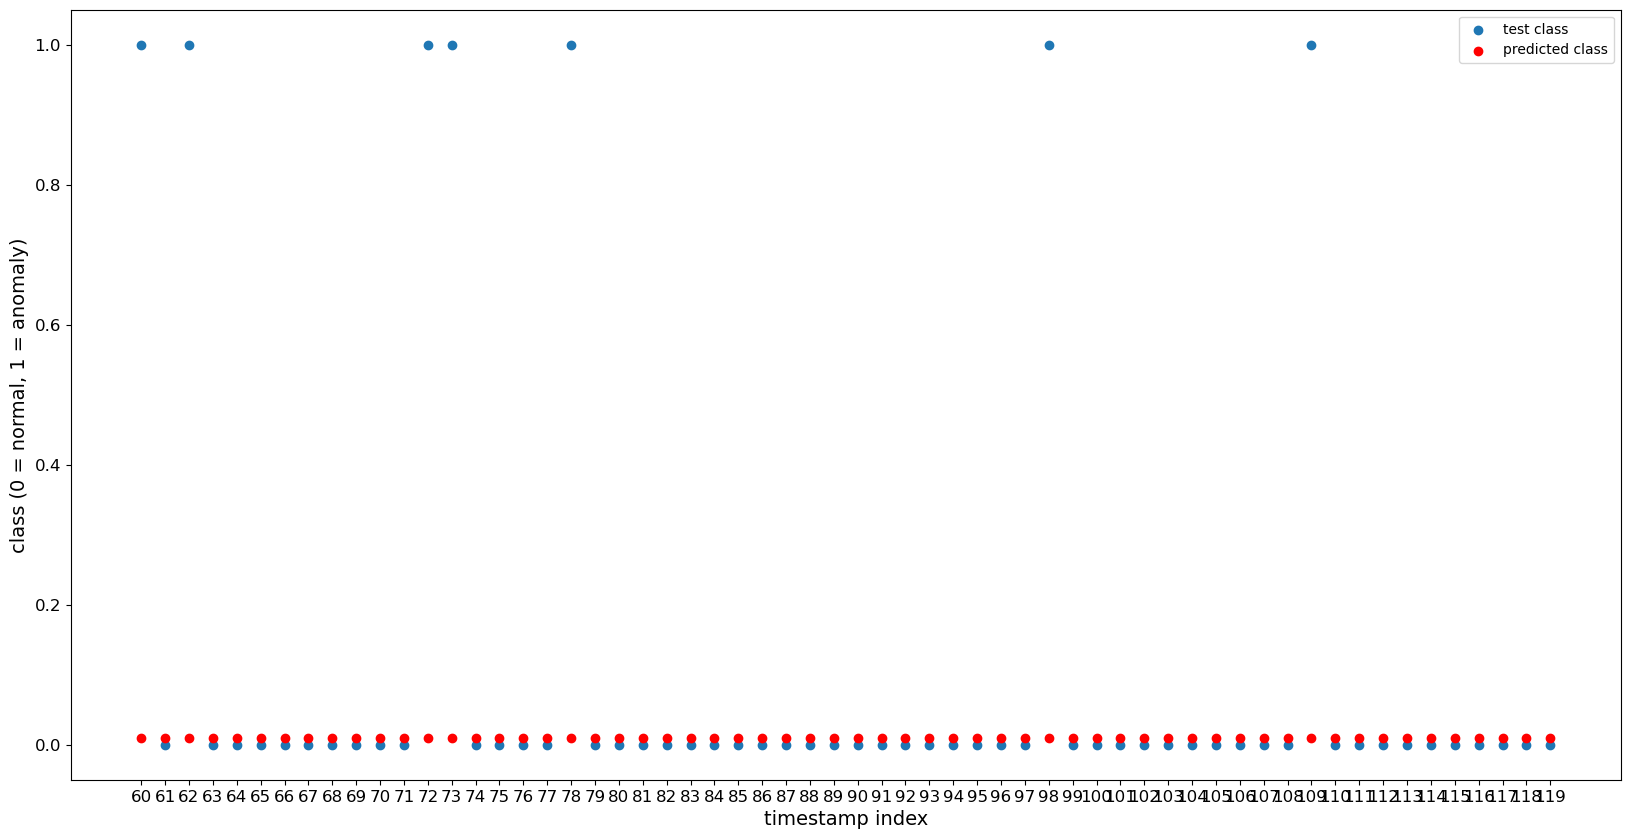

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-relu.h5
Size of the relu act model : 0.01653289794921875 Mb
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphv

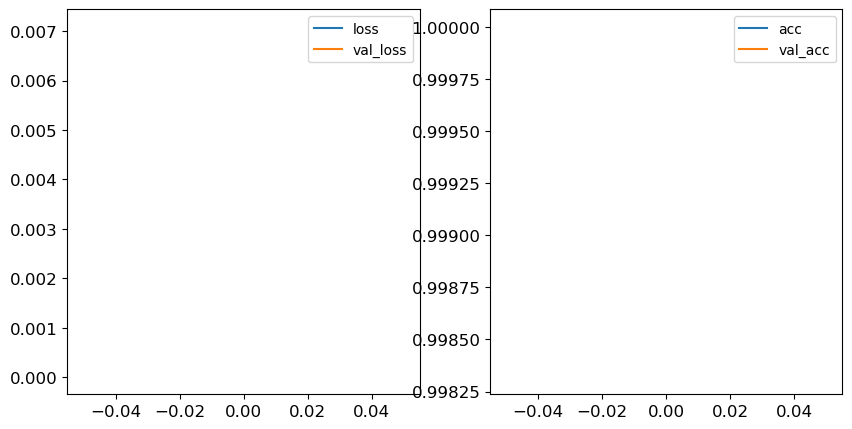

18913/18913 [==============================] - 28s 1ms/step


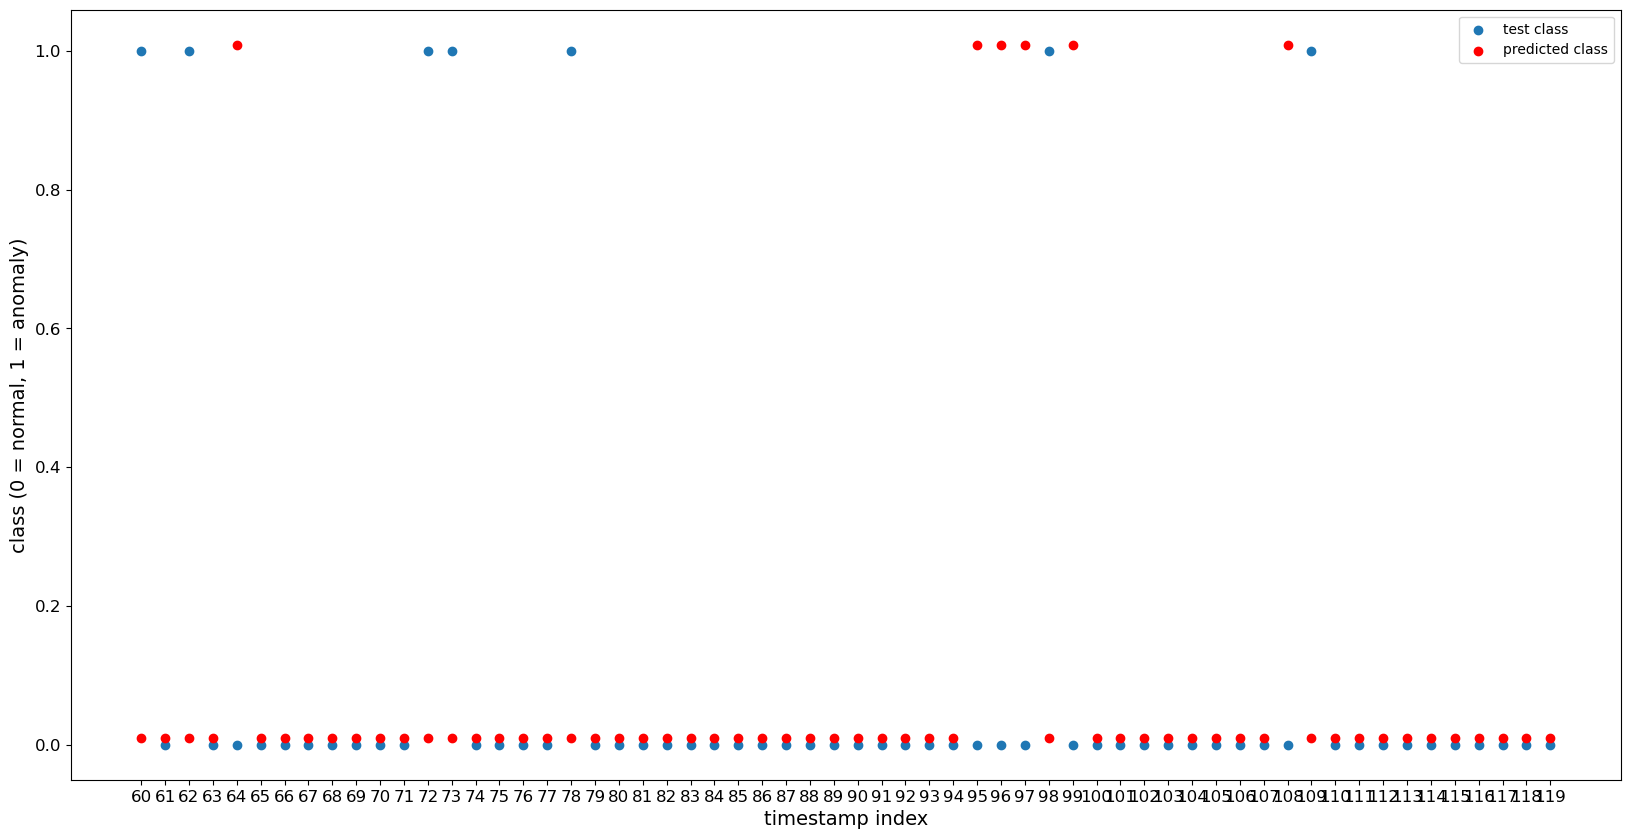

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-sigmoid.h5
Size of the sigmoid act model : 0.01653289794921875 Mb
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install 

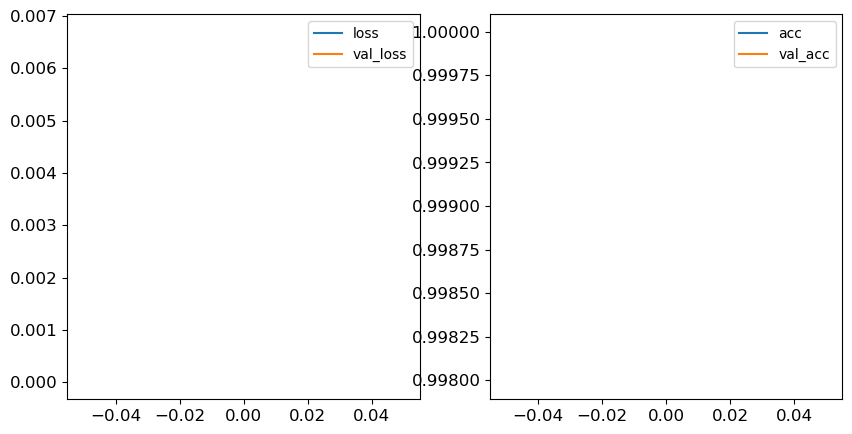

18913/18913 [==============================] - 29s 2ms/step


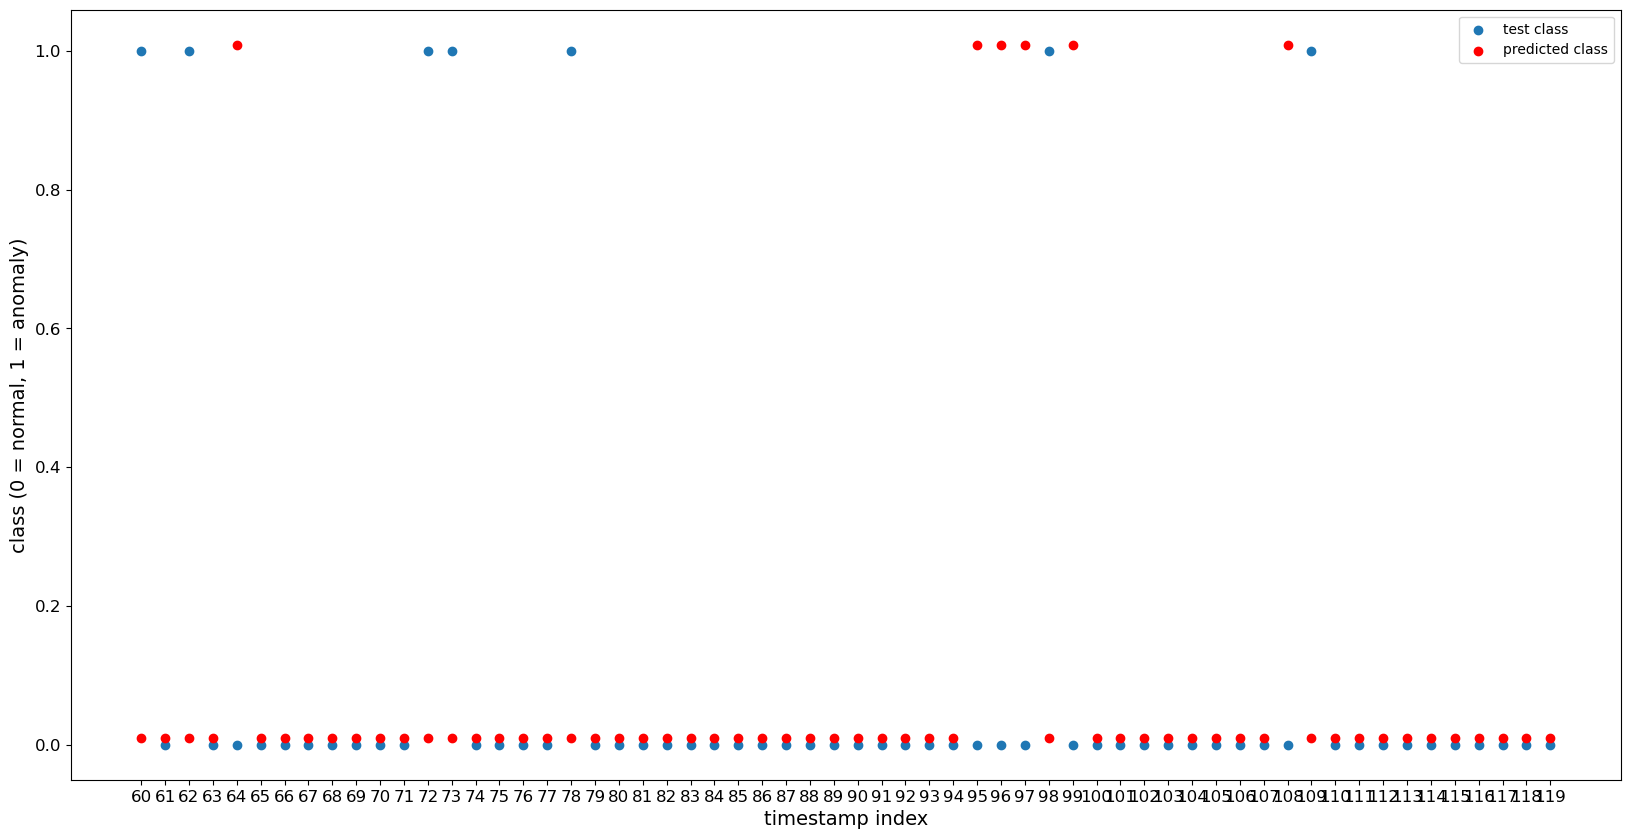

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-softmax.h5
Size of the softmax act model : 0.01653289794921875 Mb


In [92]:
acts = ['relu','sigmoid','softmax']
for act in acts:
    tf.keras.backend.clear_session()
    rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(10,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation=act)
    ])
    rnnmodel.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    print(rnnmodel.summary())
    tf.keras.utils.plot_model(rnnmodel,show_shapes=True)
    early_stop=keras.callbacks.EarlyStopping(monitor='loss',patience=10)

    rnnhistory = rnnmodel.fit(X_train,y_train,
                            epochs=1,
                            batch_size=256,
                            validation_data=(X_valid,y_valid),
                            callbacks=[early_stop])
    scores = rnnmodel.evaluate(X_test,y_test)
    print(f"Loss, Accuracy: {scores}")
    plt.subplot(1,2,1)
    plt.plot(rnnhistory.history["loss"])
    plt.plot(rnnhistory.history["val_loss"])
    plt.legend(('loss','val_loss'))
    plt.subplot(1,2,2)
    plt.plot(rnnhistory.history["accuracy"])
    plt.plot(rnnhistory.history["val_accuracy"])
    plt.legend(('acc','val_acc'))

    plt.gcf().set_size_inches((10,5))
    plt.show()

    y_pred = rnnmodel.predict(X_test)

    plot_min=60
    plot_max =120
    plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
    plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.009 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
    plt.legend(('test class','predicted class'))
    plt.xlabel('timestamp index')
    plt.ylabel('class (0 = normal, 1 = anomaly)')
    plt.xticks(ticks=range(plot_min, plot_max))
    plt.gcf().set_size_inches((20,10))
    # plt.gcf().autofmt_xdate()
    plt.show()

    saved_model_dir = 'c:/Users/User/OneDrive - Ministere de l\'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/'
    rnnmodel.save(saved_model_dir + f"lstm-{act}.h5",include_optimizer=False)
    print(f"Saving Model to: {saved_model_dir}lstm-{act}.h5")
    print(f'Size of the {act} act model : {os.path.getsize(saved_model_dir + f"lstm-{act}.h5")/float(2**20)} Mb')

### Comparison Table

| Metric\Activation | relu | sigmoid | softmax |
|---|---|---|---|
|Accuracy(%)|0.9860|0.9918|0.9813|0.9982|
|Size(MB)|0.015|0.015|0.015|0.17|
|Total Parameters|502|502|502|41002|
|Inference Time(sec)|25|25|25|48|

## Learning Rate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
18913/18913 [==============================] - 29s 2ms/step - loss: 1.0589e-07 - accuracy: 1.0000
Loss, Accuracy: [1.0588993148985537e-0

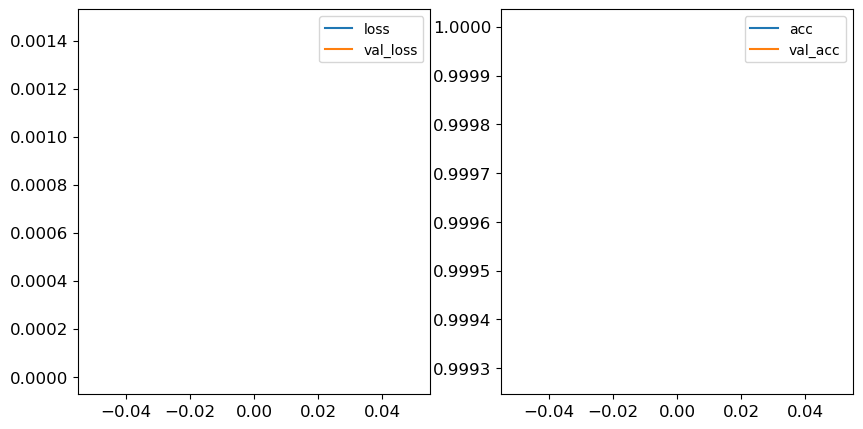

18913/18913 [==============================] - 27s 1ms/step


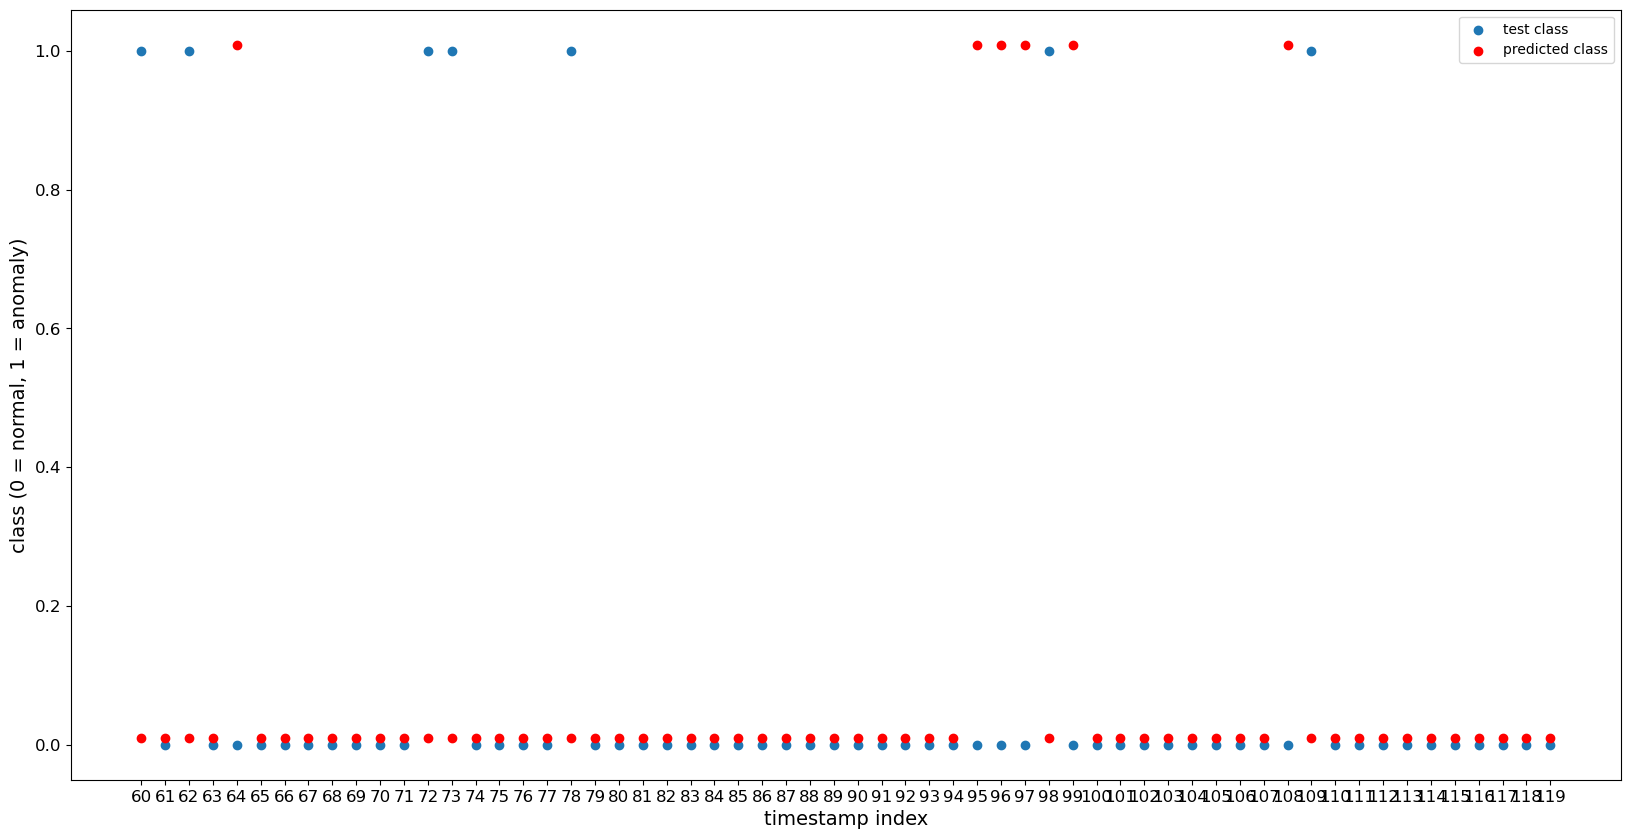

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-0.01lr.h5
Size of the 0.01 rate model : 0.01653289794921875 Mb
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install gra

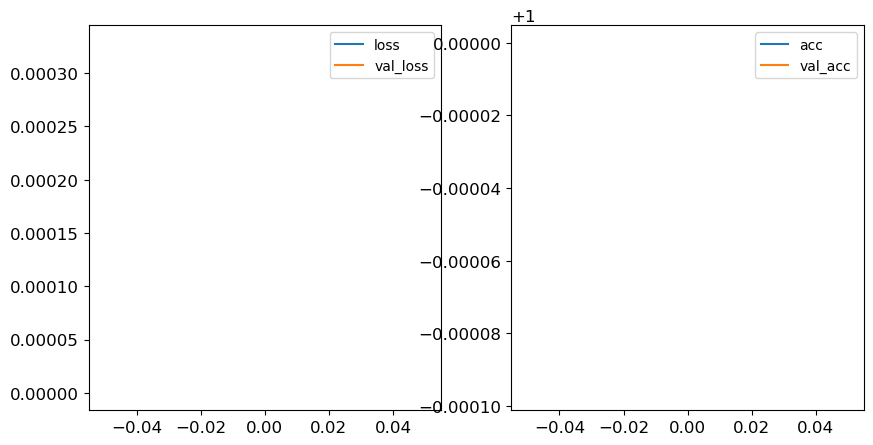

18913/18913 [==============================] - 19s 972us/step


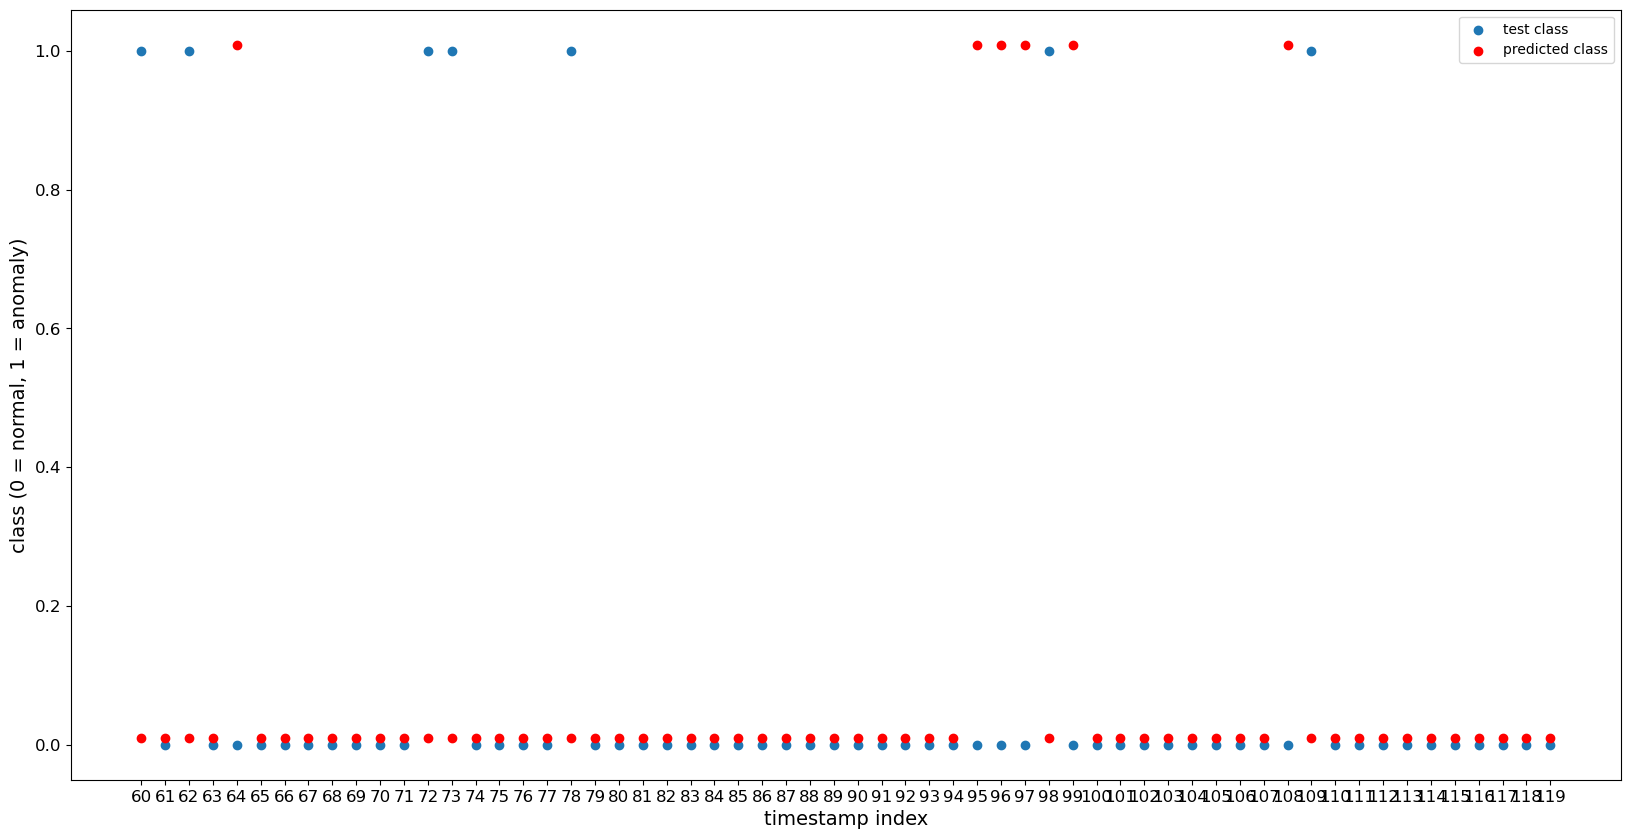

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-0.025lr.h5
Size of the 0.025 rate model : 0.01653289794921875 Mb
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install g

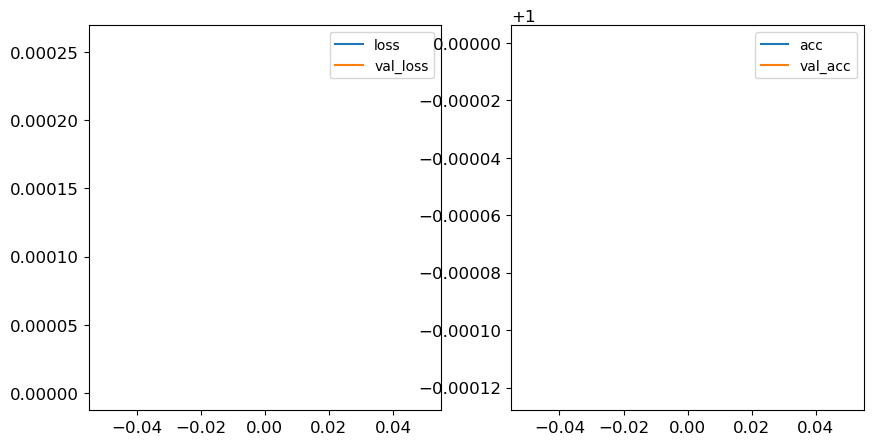

18913/18913 [==============================] - 19s 999us/step


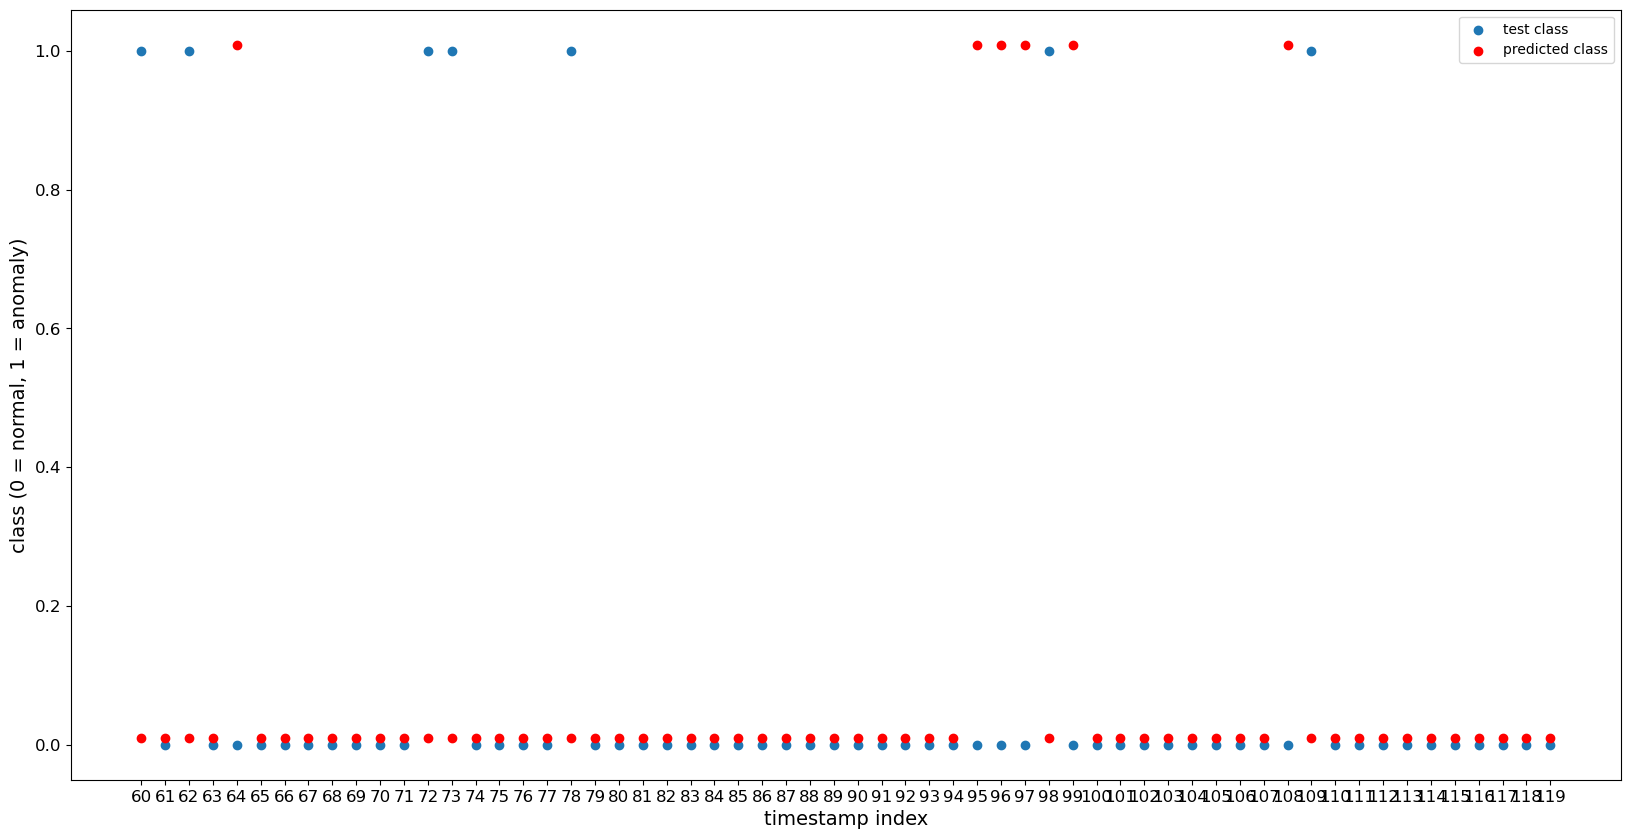

Saving Model to: c:/Users/User/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/lstm-0.1lr.h5
Size of the 0.1 rate model : 0.01653289794921875 Mb


In [93]:
learning_rate = [0.01,0.025,0.1]
for lr in learning_rate:
    tf.keras.backend.clear_session()
    rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(10,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='sigmoid')
    ])
    rnnmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    print(rnnmodel.summary())
    tf.keras.utils.plot_model(rnnmodel,show_shapes=True)
    early_stop=keras.callbacks.EarlyStopping(monitor='loss',patience=10)

    rnnhistory = rnnmodel.fit(X_train,y_train,
                            epochs=1,
                            batch_size=256,
                            validation_data=(X_valid,y_valid),
                            callbacks=[early_stop])
    scores = rnnmodel.evaluate(X_test,y_test)
    print(f"Loss, Accuracy: {scores}")
    plt.subplot(1,2,1)
    plt.plot(rnnhistory.history["loss"])
    plt.plot(rnnhistory.history["val_loss"])
    plt.legend(('loss','val_loss'))
    plt.subplot(1,2,2)
    plt.plot(rnnhistory.history["accuracy"])
    plt.plot(rnnhistory.history["val_accuracy"])
    plt.legend(('acc','val_acc'))

    plt.gcf().set_size_inches((10,5))
    plt.show()

    y_pred = rnnmodel.predict(X_test)

    plot_min=60
    plot_max =120
    plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
    plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.009 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
    plt.legend(('test class','predicted class'))
    plt.xlabel('timestamp index')
    plt.ylabel('class (0 = normal, 1 = anomaly)')
    plt.xticks(ticks=range(plot_min, plot_max))
    plt.gcf().set_size_inches((20,10))
    # plt.gcf().autofmt_xdate()
    plt.show()

    saved_model_dir = 'c:/Users/User/OneDrive - Ministere de l\'Enseignement Superieur et de la Recherche Scientifique/Bureau/CAN/CS581-CAN-DO-Project/project-data/'
    rnnmodel.save(saved_model_dir + f"lstm-{lr}lr.h5",include_optimizer=False)
    print(f"Saving Model to: {saved_model_dir}lstm-{lr}lr.h5")
    print(f'Size of the {lr} rate model : {os.path.getsize(saved_model_dir + f"lstm-{lr}lr.h5")/float(2**20)} Mb')

### Comparison Table

| Metric\Learning Rate | relu | sigmoid | 0.1 |
|---|---|---|---|
|Accuracy(%)|0.9946|0.9990|0.9987|0.9982|
|Size(MB)|0.015|0.015|0.015|0.17|
|Total Parameters|502|502|502|41002|
|Inference Time(sec)|25|25|25|48|

# Effect of features

## Without timestamp feature

giving this byte data to the network, it is an interesting experiment to see what the effect is.

In [94]:
newdf = df.drop(columns=['Timestamp'])
newdf

KeyError: "['Timestamp'] not found in axis"

In [ ]:
noTimestamp_series = newdf.to_numpy()
noTimestamp_series = noTimestamp_series[ : , :, np.newaxis] 

In [ ]:
n_features = noTimestamp_series.shape[1]
train_split = int(noTimestamp_series.shape[0]*0.8)
val_split = int(noTimestamp_series.shape[0]*0.1) + train_split
print(f'train split : {train_split}, val split: {val_split}')

X_train, y_train = noTimestamp_series[:train_split, :n_features-1], noTimestamp_series[:train_split, -1] # -1 references the last column
X_valid, y_valid = noTimestamp_series[train_split:val_split, :n_features-1], noTimestamp_series[train_split:val_split, -1]
X_test, y_test = noTimestamp_series[val_split:, :n_features-1], noTimestamp_series[val_split:, -1]


train split : 1895518, val split: 2132457


In [ ]:
X_train.shape, y_train.shape

((1895518, 11, 1), (1895518, 1))

In [ ]:
X_valid.shape,y_valid.shape

((236939, 11, 1), (236939, 1))

In [ ]:
X_test.shape, y_test.shape

((236941, 11, 1), (236941, 1))

In [ ]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
noTimestamp_series.shape, X_train.shape, y_train.shape

((2369398, 12, 1), (1895518, 11, 1), (1895518, 1))

In [ ]:
noTimestamp_rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu')
])
noTimestamp_rnnmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print(noTimestamp_rnnmodel.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
flatten_9 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
noTimestamp_rnnhistory = noTimestamp_rnnmodel.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=5, batch_size=1028)

Epoch 1/5
1844/1844 [==============================] - 9s 5ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 1.2025e-07 - val_accuracy: 1.0000
Epoch 2/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.2025e-07 - accuracy: 1.0000 - val_loss: 1.2025e-07 - val_accuracy: 1.0000
Epoch 3/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.2025e-07 - accuracy: 1.0000 - val_loss: 1.2025e-07 - val_accuracy: 1.0000
Epoch 4/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.1974e-07 - accuracy: 1.0000 - val_loss: 1.1973e-07 - val_accuracy: 1.0000
Epoch 5/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.1968e-07 - accuracy: 1.0000 - val_loss: 1.1947e-07 - val_accuracy: 1.0000


In [ ]:
scores = noTimestamp_rnnmodel.evaluate(X_test,y_test)
print(f"Accuracy: {scores[1]}")

7405/7405 [==============================] - 16s 2ms/step - loss: 1.1947e-07 - accuracy: 1.0000
Accuracy: 1.0


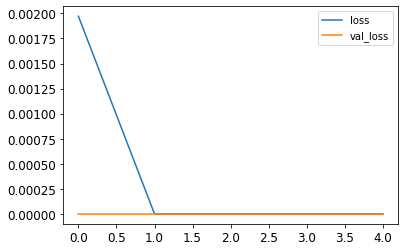

In [ ]:
plt.subplot(1,2,1)
plt.plot(noTimestamp_rnnhistory.history["loss"])
plt.plot(noTimestamp_rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(noTimestamp_rnnhistory.history["accuracy"])
plt.plot(noTimestamp_rnnhistory.history["val_accuracy"])
plt.legend(('acc','val_acc'))


plt.gcf().set_size_inches((10,5))
plt.show()

In [ ]:
y_pred = noTimestamp_rnnmodel.predict(X_test)
# plot_series(X_test[15, :, 0], y_test[15, 0], y_pred[15, 0])
# plt.show()

In [ ]:
predlist = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
predlist = predlist.reshape((predlist.shape[0],1))
y_test.shape, y_pred.shape, predlist.shape

((236941, 1), (236941, 2), (236941, 1))

In [ ]:
compdf = pd.DataFrame(predlist)
compdf['real'] = y_test
compdf = compdf.rename(columns={0:'pred'})
compdf['right label'] = np.where(compdf['pred'] == compdf['real'],True, False)
compdf

,pred,real,right label
0,1,1,True
1,1,1,True
2,1,1,True
3,1,1,True
4,1,1,True
...,...,...,...
236936,1,1,True
236937,1,1,True
236938,1,1,True
236939,1,1,True


# END